In [1]:
#!pip install matplotlib

In [2]:
import csv
from dataclasses import dataclass, field, asdict, astuple
from typing import List
import math
import matplotlib.pyplot as plt

In [3]:
def importCSV(_path):
    with open(_path,'r') as f:
        reader  = csv.reader(f) # csv의 행별로 읽어옴

        res = [x for x in reader]
        # res = []
        # for x in reader:
        #     res.append(x)
    return res

In [4]:
def exportCSV(_filename, _datas):
    f = open(_filename, 'w', newline='') # 자동줄바꿈 방지 header 이후 첫행 빈행 생성 방지
    csv_writer = csv.writer(f)
    
    for x in _datas:
        csv_writer.writerow(x)
    f.close()

## AISC 360-E section : H의 압축에 대하여

### 압축과 관련해서 부재의 단면은 두가지 종류로 나뉩니다.

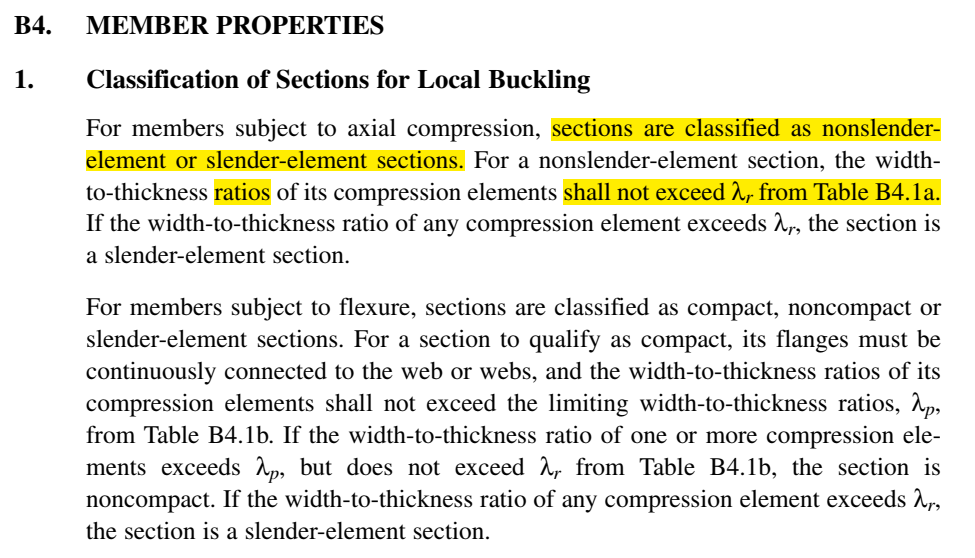

### Slender / Nonslender 판별의 기준

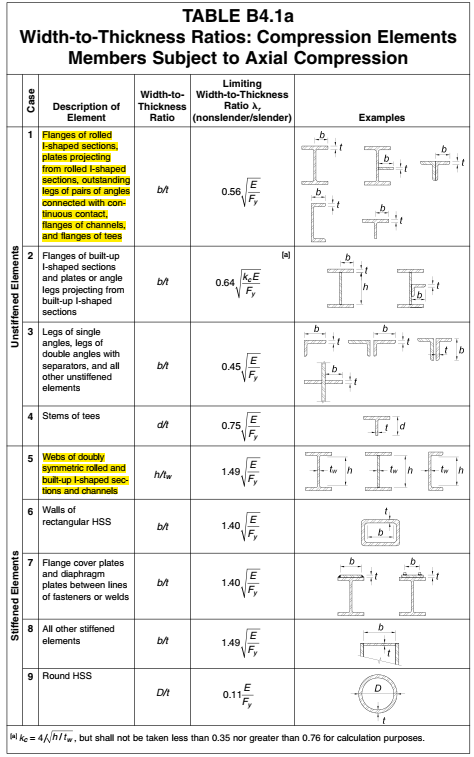

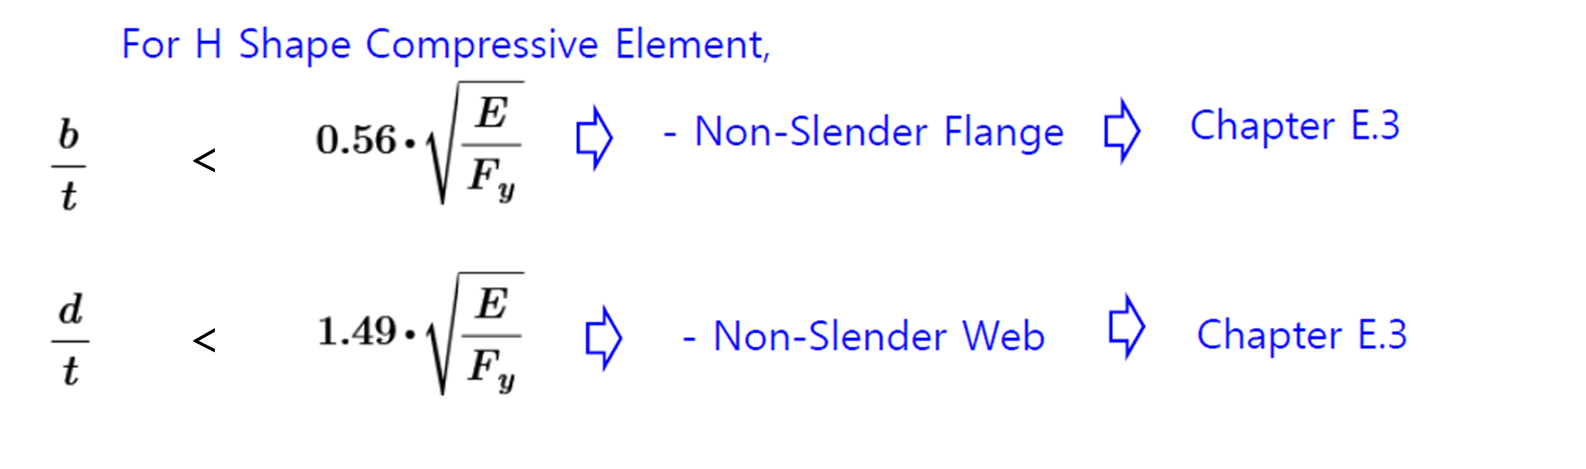

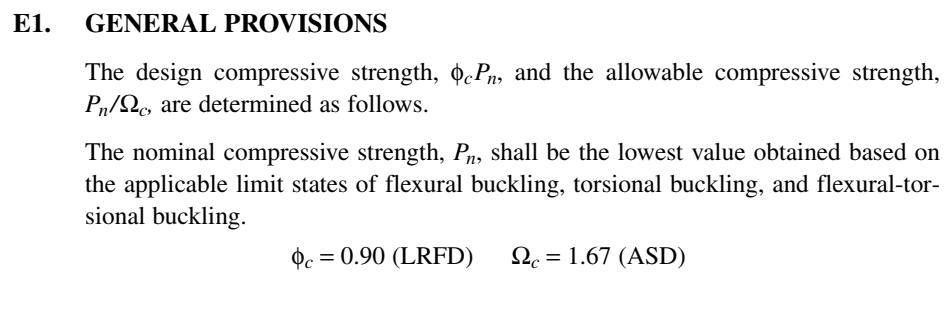

<br><br><br><br><br>

## 단면 정보 import

---  
----------------------------------------------- **사용자 입력부** -----------------------------------------------

In [5]:
input_path = 'Section Profile.csv'
# output_path = ''

---  
---

In [6]:
dfSectionProfile = importCSV(input_path)
dfHeader = dfSectionProfile.pop(0) #pop(0)의 의미 첫행을 값을 반환하고 나머지 리스트는 저장

################################################################AISC -> SectionProfile로 변경

In [7]:
@dataclass # @의 의미 데코레이터 C언어의 Struct와 비슷한 쓰임새, 각 항목의 data 특성값 부여
class PreSection:
    ID: str
    Cata: str
    h: str
    bf: str
    tw: str
    tf: str
    k: str
    
preSect1 = PreSection(*dfSectionProfile[294]) ##결과 확인용 코드

preSects = [PreSection(*x) for x in dfSectionProfile] ##결과 확인용 코드

preSects ##결과 확인용 코드

[PreSection(ID='W44X335', Cata='W', h='1120', bf='404', tw='26.2', tf='45', k='65'),
 PreSection(ID='W44X290', Cata='W', h='1110', bf='401', tw='22', tf='40.1', k='59.9'),
 PreSection(ID='W44X262', Cata='W', h='1100', bf='401', tw='19.9', tf='36.1', k='55.9'),
 PreSection(ID='W44X230', Cata='W', h='1090', bf='401', tw='18', tf='31', k='51.1'),
 PreSection(ID='W40X655', Cata='W', h='1110', bf='429', tw='50', tf='89.9', k='120'),
 PreSection(ID='W40X593', Cata='W', h='1090', bf='424', tw='45.5', tf='82', k='112'),
 PreSection(ID='W40X503', Cata='W', h='1070', bf='417', tw='39.1', tf='70.1', k='100'),
 PreSection(ID='W40X431', Cata='W', h='1050', bf='411', tw='34', tf='59.9', k='89.9'),
 PreSection(ID='W40X397', Cata='W', h='1040', bf='409', tw='31', tf='55.9', k='85.9'),
 PreSection(ID='W40X372', Cata='W', h='1030', bf='409', tw='29.5', tf='52.1', k='82'),
 PreSection(ID='W40X362', Cata='W', h='1030', bf='406', tw='28.4', tf='51.1', k='81'),
 PreSection(ID='W40X324', Cata='W', h='1020', 

<br><br><br><br><br>

## PostSection클래스 선언
### : 섹션별 물리량 도출(단면2차모멘트, 단면계수, 뒤틀림 상수) 및 웹,플렌지 슬렌더 여부 판별

In [8]:
class PostSection():

    header = ["Section ID", "Catagory", "Area(mm2)", "Weight",
              "Ix(mm4)", "Sx(mm3)", "Zx(mm3)", "rx(mm)",
              "Iy(mm4)", "Sy(mm3)", "Zy(mm3)", "ry(mm)",
              "Cw(mm6)", "J(mm4)", "rts(mm)",
              "Slenderness of Flange", "Slenderness of Web"]
######################################################### Catagory header 추가 (BH Section 구분 목적)
    def __init__(self, preSect:PreSection, dfHeader):
        fy = 345
        E = 200000
        self.fy = fy
        self.E = E 
        self.Cata = preSect.Cata
        
        def chkSlenderness(Cata, mode):
            if Cata == 'H' or 'W':
                if mode == 'flange':
                    if self.bf/(2*self.tf) < 0.56*(E/fy)**0.5:
                        return "nonslender"
                    else:
                        return "slender"

                elif mode == 'web':
                    if (self.h-2*self.k)/self.tw < 1.49*(E/fy)**0.5:
                        return "nonslender"
                    else:
                        return "slender"
                else:
                    pass
                
            elif Cata == 'BH':
                    if mode == 'flange':
                        kc = min(4/(self.h/self.tw)**0.5, 0.35)
                        if self.bf/(2*self.tf) < 0.64*(kc*E/fy)**0.5:
                            return "nonslender"
                        else:
                            return "slender"

                    elif mode == 'web':
                        if (self.h-2*self.k)/self.tw < 1.49*(E/fy)**0.5:
                            return "nonslender"
                        else:
                            return "slender"
                    else:
                        pass
            
        #self.preSect = preSect
        self.ID = preSect.ID
#         self.Cata = preSect.Cata 위에 이미 선언함
        self.h = float(preSect.h)
        self.bf = float(preSect.bf)
        self.tw = float(preSect.tw)
        self.tf = float(preSect.tf)
        self.k = float(preSect.k)

        self.Area = 2*self.tf*self.bf+(self.h-2*self.tf)*self.tw
        self.Weight = self.Area*77.22/10**6
        self.Ix = (2*(self.bf*self.tf**3/12+self.bf*self.tf*((self.h-2*self.tf)/2+self.tf/2)**2)+self.tw*(self.h-2*self.tf)**3/12) ## 단면2차모멘트
        self.Sx = self.Ix/(self.h/2) ## 탄성단면계수
        self.Zx = self.bf*self.tf*(self.h-self.tf)+0.25*(self.h-2*self.tf)**2*self.tw ## 소성단면계수
        self.rx = (self.Ix/self.Area)**0.5 ## 회전반경
        self.Iy = 2*(self.tf*(self.bf)**3/12)+(self.h-2*self.tf)*(self.tw)**3/12
        self.Sy = self.Iy/(self.bf/2)
        self.Zy = 0.5*(self.bf)**2*self.tf+0.25*(self.h-2*self.tf)*(self.tw)**2
        self.ry = (self.Iy/self.Area)**0.5
        self.Cw = (self.h-self.tf)**2*self.bf**3*self.tf/24 ## 뒤틀림 상수(mm6)
        self.J = (2*self.bf*self.tf**3+(self.h-self.tf)*self.tw**3)/3 ## 비틀림 상수(mm4)
        self.rts = ((self.Iy*self.Cw)**0.5/self.Sx)**0.5
        self.Slnd_Flange = chkSlenderness(self.Cata, "flange")
        self.Slnd_Web = chkSlenderness(self.Cata, "web")
        
        self.row = [
            self.ID, self.Cata, self.Area, self.Weight,
            self.Ix, self.Sx, self.Zx, self.rx,
            self.Iy, self.Sy, self.Zy, self.ry,
            self.Cw, self.J, self.rts,
            self.Slnd_Flange,
            self.Slnd_Web,
        ]
    
    def __repr__(self):
        return str(
            [self.ID,
            self.Cata,
            self.Area,
            self.Weight,
            self.Slnd_Flange,
            self.Slnd_Web,]
        )


In [9]:
postSect1 = PostSection(preSect1, dfHeader)

In [10]:
PostSection.header

['Section ID',
 'Catagory',
 'Area(mm2)',
 'Weight',
 'Ix(mm4)',
 'Sx(mm3)',
 'Zx(mm3)',
 'rx(mm)',
 'Iy(mm4)',
 'Sy(mm3)',
 'Zy(mm3)',
 'ry(mm)',
 'Cw(mm6)',
 'J(mm4)',
 'rts(mm)',
 'Slenderness of Flange',
 'Slenderness of Web']

In [11]:
postSect1

['H-248×124x5x8', 'H', 3144.0, 0.24277968, 'nonslender', 'slender']

In [12]:
postSect1.ID

'H-248×124x5x8'

In [13]:
postSect1.Slnd_Flange

'nonslender'

<br><br><br><br><br>

## 모든 단면정보들을 PostSection개체로 변환

In [14]:
postSects = [PostSection(x, dfHeader) for x in preSects]

# list(postSects)
postSects

[['W44X335', 'W', 63346.0, 4.89157812, 'nonslender', 'slender'],
 ['W44X290', 'W', 54815.8, 4.232876076, 'nonslender', 'slender'],
 ['W44X262', 'W', 49405.42, 3.8150865324, 'nonslender', 'slender'],
 ['W44X230', 'W', 43366.0, 3.34872252, 'nonslender', 'slender'],
 ['W40X655', 'W', 123644.20000000001, 9.547805124, 'nonslender', 'nonslender'],
 ['W40X593', 'W', 111669.0, 8.62308018, 'nonslender', 'nonslender'],
 ['W40X503', 'W', 94818.57999999999, 7.321890747599999, 'nonslender', 'nonslender'],
 ['W40X431', 'W', 80864.6, 6.244364412, 'nonslender', 'nonslender'],
 ['W40X397', 'W', 74500.4, 5.752920887999999, 'nonslender', 'nonslender'],
 ['W40X372', 'W', 69928.9, 5.3999096579999994, 'nonslender', 'nonslender'],
 ['W40X362', 'W', 67842.72, 5.2388148384, 'nonslender', 'nonslender'],
 ['W40X324', 'W', 60739.2, 4.690281023999999, 'nonslender', 'nonslender'],
 ['W40X297', 'W', 55462.119999999995, 4.2827849064, 'nonslender', 'slender'],
 ['W40X277', 'W', 51778.979999999996, 3.9983728355999992, 

<br><br><br><br><br>

## 슬렌더여부 판별된 단면 별 정보를 엑셀로 Export

In [15]:
dfOut = [PostSection.header]+[x.row for x in postSects]

In [16]:
dfOut

[['Section ID',
  'Catagory',
  'Area(mm2)',
  'Weight',
  'Ix(mm4)',
  'Sx(mm3)',
  'Zx(mm3)',
  'rx(mm)',
  'Iy(mm4)',
  'Sy(mm3)',
  'Zy(mm3)',
  'ry(mm)',
  'Cw(mm6)',
  'J(mm4)',
  'rts(mm)',
  'Slenderness of Flange',
  'Slenderness of Web'],
 ['W44X335',
  'W',
  63346.0,
  4.89157812,
  12896554283.333334,
  23029561.220238097,
  26492395.0,
  451.2084736087665,
  496088169.1533333,
  2455882.025511551,
  3849118.3,
  88.49522479169455,
  142876991175000.0,
  30987527.53333333,
  107.51955536379717,
  'nonslender',
  'slender'],
 ['W44X290',
  'W',
  54815.8,
  4.232876076,
  11209808318.219332,
  20197852.825620417,
  23036783.21,
  452.2163026626787,
  431863135.8833333,
  2153930.852285952,
  3348665.85,
  88.7605916872622,
  123325425857382.95,
  21035406.134000003,
  106.89246389731599,
  'nonslender',
  'slender'],
 ['W44X262',
  'W',
  49405.42,
  3.8150865324,
  9996290342.73273,
  18175073.350423146,
  20656577.669,
  449.8131349324051,
  388636865.98768336,
  1938338.

In [17]:
exportCSV("Section Profile_WithSlenderness.csv", dfOut)

<br><br><br><br><br>

## 유효 좌굴길이 입력을 위한 EffectiveLength클래스 선언:
### 지점 조건에 따른 유효길이 계수 도출

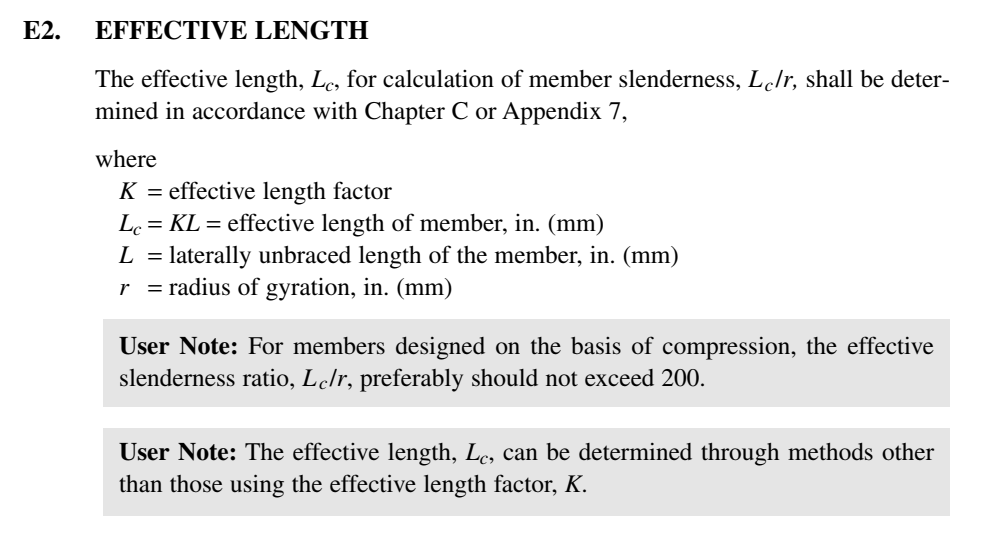

In [18]:
class EffectiveLength(): ## _length 인수로는 x축 y축 순서로 비지지길이를 입력하면 됨(동일할 경우 1개만 입력 가능)
    def __init__(self, mode, cond, *_length):
        factorTable = {
            "a": (0.5, 0.65),
            "b": (0.7, 0.80),
            "c": (1.0, 1.2),
            "d": (1.0, 1.0),
            "e": (2.0, 2.1),
            "f": (2.0, 2.0),
        }
        
        if len(_length) == 1:
            self.unbracedLength_x = _length[0]
            self.unbracedLength_y = _length[0]
        elif len(_length) ==2:
            self.unbracedLength_x = _length[0]
            self.unbracedLength_y = _length[1]
        
        self.unbracedLength = (self.unbracedLength_x, self.unbracedLength_y)
        self.factorK = None
        
        if mode == "theoretical":
            self.factorK = factorTable[cond][0]
            
        elif mode == "recommended":
            self.factorK = factorTable[cond][1]
            
        else:
            self.factorK = 'Please select mode("theoretical" or "recommended")'

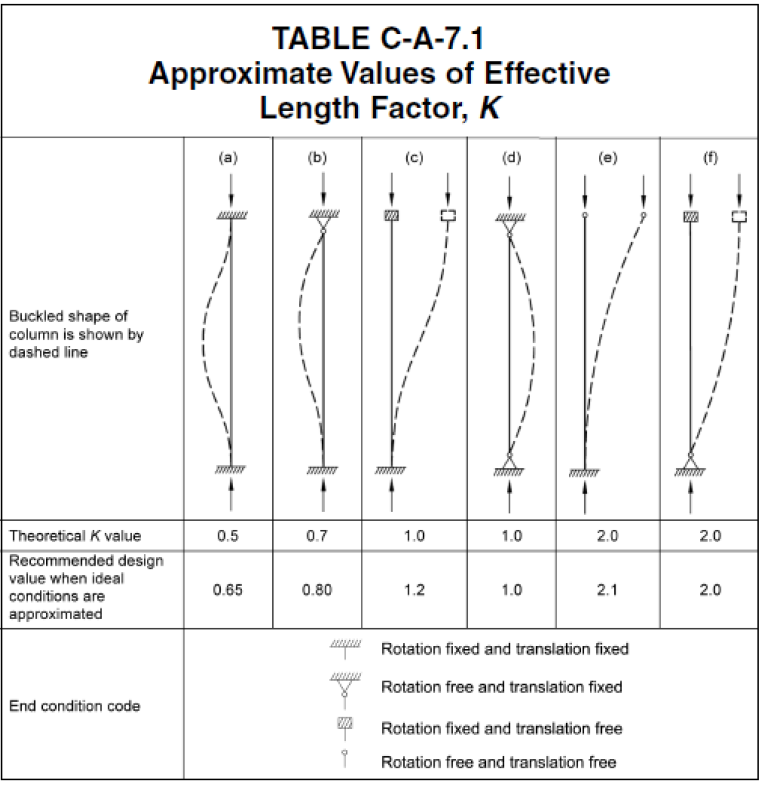

In [19]:
effLength = EffectiveLength("recommended","d" ,6000, 6000) ## 실무에서는 축마다 컨디션 지정할 필요는 없어보이나 필요하면 추후 구현
print(effLength.unbracedLength_y)
print(effLength.factorK)

6000
1.0


<br><br><br><br><br>

## 부재 해석을 위한 DesignBase클래스 선언
### : 유효좌굴길이, 세장비, 탄성 좌굴 응력, 좌굴임계응력, 공칭강도, 설계강도 도출

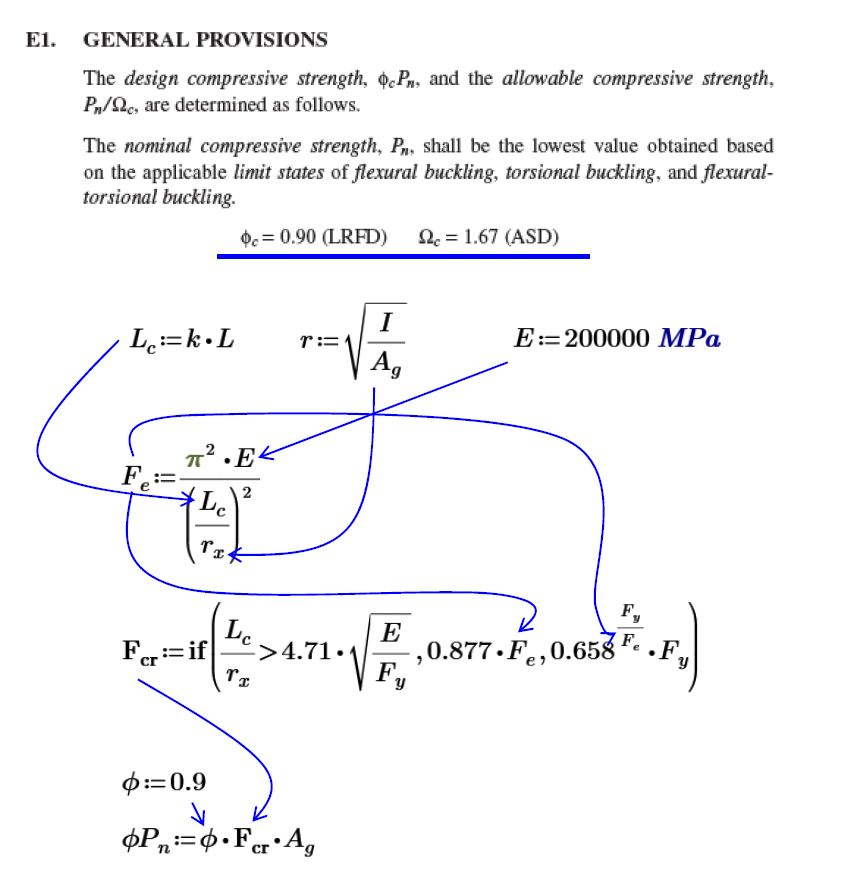

In [20]:
class DesignBase():
    
    def __init__(self, _load, _postSect:PostSection, _effLength:EffectiveLength):
        self._load = _load
        self._postSect = _postSect
        self._effLength = _effLength
        self.fy = _postSect.fy ## 항복 강도
        self.E = _postSect.E ## 탄성계수
        self.Ag = _postSect.Area
        self.Slnd_Flange = _postSect.Slnd_Flange
        self.Slnd_Web = _postSect.Slnd_Web
        self.tw = _postSect.tw
        self.tf = _postSect.tf
        self.bf = _postSect.bf
        self.h = _postSect.h
        
    def find_Lc(self):  ### 축방향 별로 유효길이 다른 것 구현해야 함###
        Lc_x = self._effLength.factorK * self._effLength.unbracedLength_x
        Lc_y = self._effLength.factorK * self._effLength.unbracedLength_y
        return (Lc_x, Lc_y)
    
    def find_r(self): ## 회전 반경
        rx = self._postSect.rx
        ry = self._postSect.ry
        return (rx, ry)
    
    def find_Lc_r(self): ## 세장비 (effective slenderness ratio)
        Lc_rx = self.find_Lc()[0]/self.find_r()[0]
        Lc_ry = self.find_Lc()[1]/self.find_r()[1]
        
        def chk_IsLcExceed():
            if Lc_rx < 200 and Lc_ry < 200:
                return (Lc_rx, Lc_ry)
            else:
                return (Lc_rx, Lc_ry, "ratio exceed 200")
            
        return chk_IsLcExceed()
    
    def find_Fe(self): ## 탄성 좌굴 응력
        r = self.find_r()
        Lc_rx = self.find_Lc_r()[0]
        Lc_ry = self.find_Lc_r()[1]

        Fe_x = math.pi**2*self.E/Lc_rx**2
        Fe_y = math.pi**2*self.E/Lc_ry**2

        return (Fe_x, Fe_y)
        
    def find_Fcr(self): ## 좌굴임계응력

        Fe_x = self.find_Fe()[0]
        Fe_y = self.find_Fe()[1]
        
        Cata = self._postSect.Cata

        if self.find_Lc_r()[0] > 4.71*(self.E/self.fy)**0.5:
            Fcr_x = 0.877*Fe_x
        else:
            Fcr_x = 0.658**(self.fy/Fe_x)*self.fy

        if self.find_Lc_r()[1] > 4.71*(self.E/self.fy)**0.5:
            Fcr_y = 0.877*Fe_y
        else:
            Fcr_y = 0.658**(self.fy/Fe_y)*self.fy

        return min(Fcr_x, Fcr_y)
############################################################### 여기서 부터 Slender
    def find_slender_web(self): 
        Cata = self._postSect.Cata

        if Cata == "H" or "W" or "BH":
            c1 = 0.18
        else:
            c1 = 0.22   
        
        c2 = (1-(1-4*c1)**0.5)/(2*c1)
        h = self.h-(2*self.tf)
        λ = h/self.tw
        λr = 1.49*(self.E/self.fy)**0.5
        Fel = (c2*λr/λ)**2 * self.fy

        if λ<=λr*(self.fy/self.find_Fcr())**0.5:
            he = h
        else:
            he = h*(1-c1*(Fel/self.find_Fcr())**0.5)*(Fel/self.find_Fcr())**0.5
            
        return he
    
    def find_slender_flange(self): ###### slender 부재일경우
        Cata = self._postSect.Cata
    
        kc = 4/(self.h/self.tw)**0.5
        λ = self.bf/(2*self.tf)
        b = self.bf/2
        
        
        if Cata == "H" or "W" or "BH":
            if Cata == "H" or "W":
                c1 = 0.18
                λr = 0.56*(kc*self.E/self.fy)**0.5
                
            elif Cata == "BH":
                c1 = 0.18
                λr = 0.64*(kc*self.E/self.fy)**0.5

        else:
            c1 = 0.22
            
        c2 = (1-(1-4*c1)**0.5)/(2*c1)
        Fel = (c2*λr/λ)**2 * self.fy

        if λ<=λr*(self.fy/self.find_Fcr())**0.5:
            be = b
            
        else:
            be = b*(1-c1*(Fel/self.find_Fcr())**0.5)*(Fel/self.find_Fcr())**0.5
            
        return be

    def find_Ae(self):
        Slnd_Web = self._postSect.Slnd_Web
        Slnd_Flange = self._postSect.Slnd_Flange
        he = self.find_slender_web()
        be = self.find_slender_flange()
        
        if Slnd_Web == "nonslender" and Slnd_Flange == "nonslender":
            Ae = self.Ag
        else:
            Ae = he*self.tw + 2*self.tf*(2*be)
        return Ae
########################################################################################3     

    def find_Pn(self): ## 공칭 강도 (nominal compressive strength)
        return self.find_Fcr() * self.find_Ae()/1000
    
    def find_ϕPn(self): ## 설계 강도 (design compressive strength)
        return 0.9 * self.find_Pn()
        
    def compression_check(self):
        def chk_result():
            if self.find_ϕPn() > self._load:
                return "O.K."
            else:
                return "N.G."
        return [f"ϕPn: {self.find_ϕPn()}KN", f"loading: {self._load}", f"result: {chk_result()}"]
        

# 1. 부재별 Ae를 위에 export된 csv slenderness 옆에 열을 추가해서 기입하고자 함
# 2. Export 관련 코드가 위에 PostSection 부분과 연계가 되어있는데 Export 부분을 따로 분리하여 Compression_Check 이후 결과 값으로 나오게 하는게 바람직 할듯
# 3. 이후 CSV의 섹션들을 단위중량으로 ascending 이후 소요공칭강도를 빨간선으로 표현해서 근처에 가장 가까운 단면을 선정하는 로직으로 진행

In [21]:
#

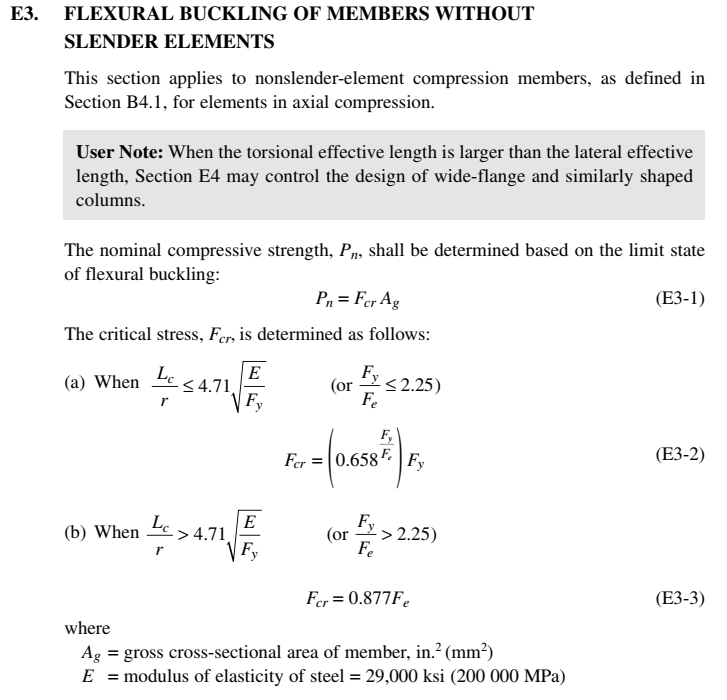

<br><br><br><br><br>


## 예제 풀이 - EXAMPLE E.1A W-SHAPE COLUMN DESIGN WITH PINNED ENDS

---  
----------------------------------------------- **사용자 입력부** -----------------------------------------------

In [22]:
deadLoad = 622.751024 ## kN 단위 입력
liveLoad = 1868.253072  ## kN 단위 입력

designLoad = (1.2 * deadLoad) + (1.6 * liveLoad)
print(designLoad)

3736.506144


In [23]:
타겟섹션기입 = "H-248×124x5x8"

---  
---

### 해석 대상 단면 데이터 세팅

In [24]:
targetSection = list(filter(lambda x: x.ID == 타겟섹션기입, postSects))[0]

targetSection

['H-248×124x5x8', 'H', 3144.0, 0.24277968, 'nonslender', 'slender']

In [25]:
targetTest = list(filter(lambda x: x.ID == "H-248×124x5x8", postSects))[0]

### 해석 조건이 될 비지지길이 데이터 입력

#### Case 1. 강축, 약축의 비지지길이 동일 케이스

In [26]:
effLength0 = EffectiveLength("recommended", "d", 4572)

effLength0.unbracedLength_y

4572

In [27]:
res0 = DesignBase(designLoad, targetSection, effLength0)


print(res0.find_Fe())
print(res0.find_Fcr())
print(res0.find_slender_web())
print(res0.find_slender_flange())
print(res0.find_Ae())

(1014.6940952908875, 76.42777404367398)
67.02715783630208
232.0
62.0
3144.0


In [28]:
res0.find_Lc_r()

(44.10596250745062, 160.70865449283127)

In [29]:
res_Test = DesignBase(designLoad, targetTest, effLength0)
res_Test.find_Lc_r()

(44.10596250745062, 160.70865449283127)

In [30]:
res0.compression_check()

['ϕPn: 189.6600458136004KN', 'loading: 3736.506144', 'result: N.G.']

#### Case 2. 강축, 약축의 비지지길이 동일 케이스(약축 방향에서 전체길이 중간에 부재 지지 가정)

In [31]:
effLength1 = EffectiveLength("recommended", "d", 9144, 4572)

effLength1.unbracedLength_y

4572

In [32]:
res1 = DesignBase(designLoad, targetSection, effLength1)


print(res1.find_Fe())
print(res1.find_Fcr())
print(res1.find_Ae())

(253.67352382272188, 76.42777404367398)
67.02715783630208
3144.0


In [33]:
res1.compression_check()

['ϕPn: 189.6600458136004KN', 'loading: 3736.506144', 'result: N.G.']

<br><br><br><br><br>


## 그렇다면 기둥이 길어지면 강도가 얼마나 약해질까?

<br>

### A. 극단적으로 길이가 20m로 늘어난 기둥에 대한 검토

In [34]:
effLength2 = EffectiveLength("recommended", "d", 20000)
res2 = DesignBase(designLoad, targetSection, effLength2)

In [35]:
res2.compression_check()

['ϕPn: 9.911247087725295KN', 'loading: 3736.506144', 'result: N.G.']

<br>

### B. 1m에서 20m에 이르기까지, 기둥의 길이변화에 따른 강도 변화 그래프

In [36]:
efLengthsRange = range(1000,20000)
efLengthsRange

range(1000, 20000)

In [37]:
efLengthObjs = [EffectiveLength("recommended", "d", x) for x in efLengthsRange]
dsnBases = [DesignBase(designLoad, targetSection, x) for x in efLengthObjs]

In [38]:
nomStrenths = [x.find_ϕPn() for x in dsnBases]

<br>

#### 예제에 해당하는 섹션과 유효길이 확보

In [39]:
efLength_sample = 9144
efLengthObj_sample = EffectiveLength("recommended", "d", efLength_sample)
dsnBase_sample = DesignBase(designLoad, targetSection, efLengthObj_sample)

<br>

#### 가로축과 세로축에 해당하는 데이터 준비 및 그래프 작도

Text(0, 0.5, 'Nominal Strength')

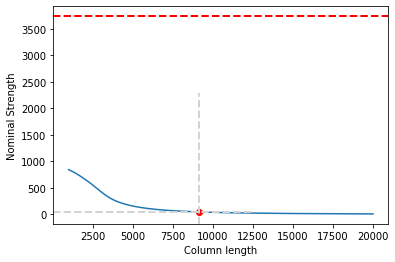

In [40]:
plt.plot(efLengthsRange, nomStrenths, label='kN')
plt.plot(efLength_sample, dsnBase_sample.find_ϕPn(), 'ro')
plt.axhline(designLoad, 0, 1, color='red', linestyle='--', linewidth=2)
plt.axhline(dsnBase_sample.find_ϕPn(), 0, 0.6, color='lightgray', linestyle='--', linewidth=2)
plt.axvline(efLength_sample, 0, 0.6, color='lightgray', linestyle='--', linewidth=2)

plt.xlabel("Column length")
plt.ylabel("Nominal Strength")

<br><br><br><br><br><br><br><br><br>

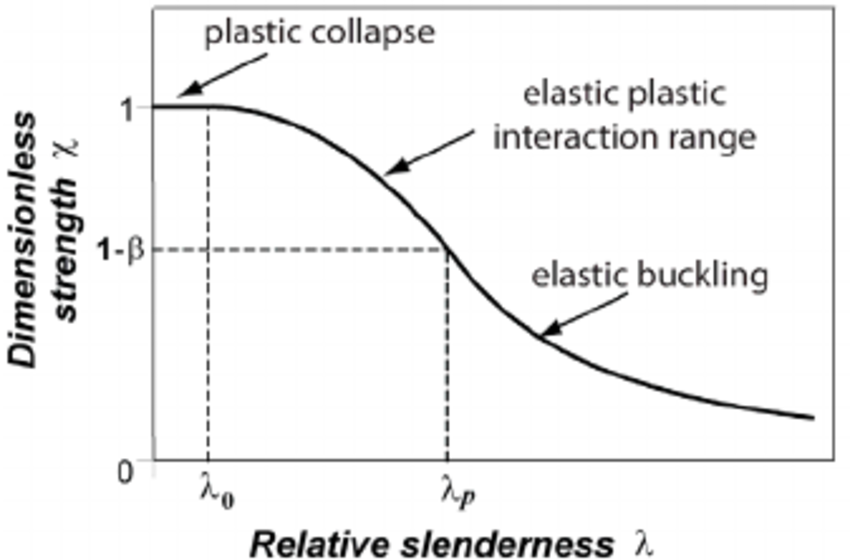

<br><br><br><br><br>


## 기둥이 일정한 길이일때, 단면 변화로 인한 강도의 변화 추이

<br>

### 전체 단면 목록 중에서 웹, 플랜지 모두 nonslender 인 단면만 필터링

In [41]:
postSects

All_postSects = list(postSects)

dsnBases_allSection = [DesignBase(designLoad, x, efLengthObj_sample) for x in All_postSects]
dfIdxRange = range(len(dsnBases_allSection))
print(dfIdxRange)

range(0, 377)


In [42]:
All_postSects

[['W44X335', 'W', 63346.0, 4.89157812, 'nonslender', 'slender'],
 ['W44X290', 'W', 54815.8, 4.232876076, 'nonslender', 'slender'],
 ['W44X262', 'W', 49405.42, 3.8150865324, 'nonslender', 'slender'],
 ['W44X230', 'W', 43366.0, 3.34872252, 'nonslender', 'slender'],
 ['W40X655', 'W', 123644.20000000001, 9.547805124, 'nonslender', 'nonslender'],
 ['W40X593', 'W', 111669.0, 8.62308018, 'nonslender', 'nonslender'],
 ['W40X503', 'W', 94818.57999999999, 7.321890747599999, 'nonslender', 'nonslender'],
 ['W40X431', 'W', 80864.6, 6.244364412, 'nonslender', 'nonslender'],
 ['W40X397', 'W', 74500.4, 5.752920887999999, 'nonslender', 'nonslender'],
 ['W40X372', 'W', 69928.9, 5.3999096579999994, 'nonslender', 'nonslender'],
 ['W40X362', 'W', 67842.72, 5.2388148384, 'nonslender', 'nonslender'],
 ['W40X324', 'W', 60739.2, 4.690281023999999, 'nonslender', 'nonslender'],
 ['W40X297', 'W', 55462.119999999995, 4.2827849064, 'nonslender', 'slender'],
 ['W40X277', 'W', 51778.979999999996, 3.9983728355999992, 

<br>

### 예제에 해당하는 섹션과 인덱스 번호 확보

In [43]:
target = list(filter(lambda x: x.ID == "W14X132", postSects))[0]
targetIdx = nonslender_postSects.index(target)

NameError: name 'nonslender_postSects' is not defined

<br>

### 가로축과 세로축에 해당하는 데이터 준비 및 그래프 작도

In [ ]:
nomStrenths_allSection = [x.find_ϕPn() for x in dsnBases_allSection]

In [ ]:
plt.plot(dfIdxRange, nomStrenths_allSection, label='kN')

plt.axhline(designLoad, 0, 1, color='red', linestyle='--', linewidth=2)

plt.plot(targetIdx, dsnBases_allSection[targetIdx].find_ϕPn(), 'ro')

plt.xlabel("Section Index")
plt.ylabel("Nominal Strength")

아래 그래프에서 검은색 음영 구간의 단면들은 설계강도가 소요강도보다 낮게 계산되므로 사용할 수 없음을 의미합니다.

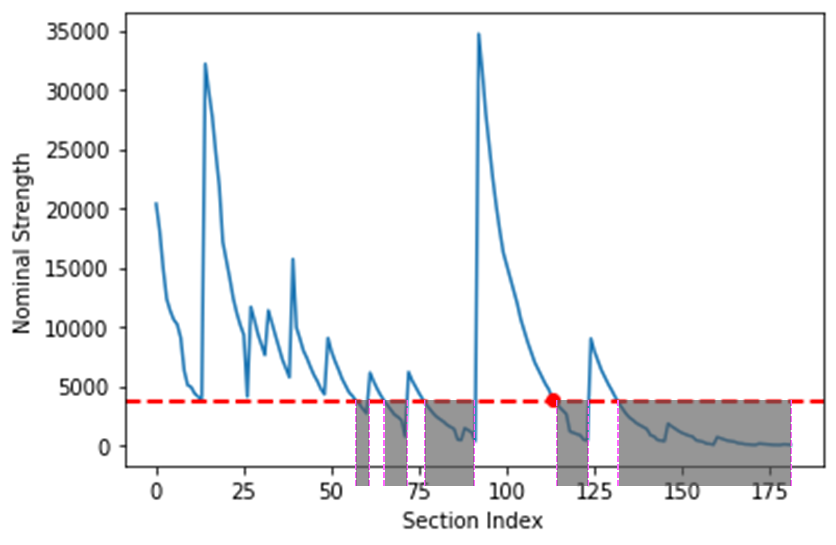

## W14 단면 시리즈 구간 - 확대 그래프 작성

<br>

### 가로축과 세로축에 해당하는 데이터 준비

In [ ]:
_targetRangeSections = list(filter(lambda x: "W14" in x.ID, postSects))
targetRangeSections = list(filter(lambda x: x.Slnd_Flange == "nonslender" and x.Slnd_Web == "nonslender", _targetRangeSections))

In [ ]:
dsnBases_targetRangeSections = [DesignBase(designLoad, x, efLengthObj_sample) for x in targetRangeSections]
dfIdxRange_targetRangeSections = range(len(dsnBases_targetRangeSections))
print(dfIdxRange_targetRangeSections)

In [ ]:
nomStrenths_targetRangeSections = [x.find_ϕPn() for x in dsnBases_targetRangeSections]

<br>

### 예제에 해당하는 섹션과 인덱스 번호 확보

In [ ]:
targetIdx_2 = targetRangeSections.index(target)
targetIdx_2

<br>

### 그래프 작도

In [ ]:
plt.plot(dfIdxRange_targetRangeSections, nomStrenths_targetRangeSections, label='kN')

plt.axhline(designLoad, 0, 1, color='red', linestyle='--', linewidth=2)
plt.plot(targetIdx_2, dsnBases_targetRangeSections[targetIdx_2].find_ϕPn(), 'ro')

plt.xlabel("Section Index")
plt.ylabel("Nominal Strength")

**W14 단면 시리즈 전체 목록**

In [ ]:
targetRangeSections

**사용할 수 없는 단면의 목록**

In [ ]:
targetRangeSections[22:]